<a href="https://colab.research.google.com/github/avrymi-asraf/IDL-huji/blob/main/ex3_IDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

!pip install torchtext
# !pip install torch
# ! pip install pandas
# ! pip install numpy
!wget -O /content/IMDB_Dataset.csv https://raw.githubusercontent.com/avrymi-asraf/IDL-huji/main/ex3/IMDB%20Dataset.csv


#https://raw.githubusercontent.com/avrymi-asraf/IDL-huji/main/ex3/IMDB%20Dataset.csv

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [5]:
import torch
# from torchtext.legacy.data import Field
import torchtext as tx
from torchtext.vocab import GloVe
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
import re
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch as tr
import torch
from torch.nn.functional import pad
import torch.nn as nn
import numpy as np

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MAX_LENGTH = 100
embedding_size = 100
Train_size=30000



def review_clean(text):
    text = re.sub(r'[^A-Za-z]+', ' ', text)  # remove non alphabetic character
    text = re.sub(r'https?:/\/\S+', ' ', text)  # remove links
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)  # remove singale char
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


def tokinize(s):
    s = review_clean(s).lower()
    splited = s.split()
    return splited[:MAX_LENGTH]


def load_data_set(load_my_reviews=False):
    data=pd.read_csv("/content/IMDB_Dataset.csv")
    train_data=data[:Train_size]
    train_iter=ReviewDataset(train_data["review"],train_data["sentiment"])
    test_data=data[Train_size:]
    if load_my_reviews:
        my_data = pd.DataFrame({"review": my_test_texts, "sentiment": my_test_labels})
        # test_data=test_data.append(my_data)
        test_data = pd.concat([test_data, my_data], ignore_index=True)
    test_data=test_data.reset_index(drop=True)
    test_iter=ReviewDataset(test_data["review"],test_data["sentiment"])
    return train_iter, test_iter


embadding = GloVe(name='6B', dim=embedding_size)
tokenizer = get_tokenizer(tokenizer=tokinize)


def preprocess_review(s):
    cleaned = tokinize(s)
    embadded = embadding.get_vecs_by_tokens(cleaned)
    if embadded.shape[0] != 100 or embadded.shape[1] != 100:
        embadded = torch.nn.functional.pad(embadded, (0, 0, 0, MAX_LENGTH - embadded.shape[0]))
    return torch.unsqueeze(embadded, 0)


def preprocess_label(label):
    return [0.0, 1.0] if label == "negative" else [1.0, 0.0]


def collact_batch(batch):
    label_list = []
    review_list = []
    embadding_list=[]
    for  review,label in batch:
        label_list.append(preprocess_label(label))### label
        review_list.append(tokinize(review))### the  actuall review
        processed_review = preprocess_review(review).detach()
        embadding_list.append(processed_review) ### the embedding vectors
    label_list = torch.tensor(label_list, dtype=torch.float32).reshape((-1, 2))
    embadding_tensor= torch.cat(embadding_list)
    return label_list.to(device), embadding_tensor.to(device) ,review_list


##########################
# ADD YOUR OWN TEST TEXT #
##########################

my_test_texts = []
my_test_texts.append(" The movie had stunning cinematography and top-notch acting,\
        which I really enjoyed. However, the plot was disappointing and lacked coherence. \
        The soundtrack was perfect, adding depth to the scenes, but the pacing was inconsistent, \
        dragging in some parts and rushing in others. Overall, while there were some elements I loved, \
        the significant flaws were hard to ignore.")
my_test_texts.append("An emotionally charged masterpiece, blending nuanced acting with\
          a captivating storyline. The cinematography paints each scene with artistic brilliance,\
          complementing its intricate narrative. While its deliberate pace may divide audiences,\
          I found it enhanced the film's depth and suspense. A thought-provoking gem.")
my_test_texts.append("The film offers a unique perspective, challenging conventions with its bold narrative choices.\
      The performances are subtly powerful, capturing the complexity of human emotions.\
      Visually stunning, each frame is a work of art. \
      While its unconventional storytelling may not be for everyone,\
      I appreciated its originality and depth.")
my_test_labels = ["neg", "pos", "pos"]

##########################
##########################


class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, review_list, labels):
        'Initialization'
        self.labels = labels
        self.reviews = review_list

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        X = self.reviews[index]
        y = self.labels[index]
        return X, y



def get_data_set(batch_size, toy=False):
        train_data, test_data = load_data_set(load_my_reviews=toy)
        train_dataloader = DataLoader(train_data, batch_size=batch_size,
                                      shuffle=True, collate_fn=collact_batch)
        test_dataloader = DataLoader(test_data, batch_size=batch_size,
                                     shuffle=True, collate_fn=collact_batch)
        return train_dataloader, test_dataloader, MAX_LENGTH, embedding_size




.vector_cache/glove.6B.zip: 862MB [02:42, 5.30MB/s]                           
100%|█████████▉| 399999/400000 [00:23<00:00, 17030.75it/s]


In [21]:
########################################################################
########################################################################
##
##                     BEST TEAM EVER
                                            ##                     ##
##                                                                    ##
########################################################################
########################################################################


# import loader as ld


batch_size = 32
output_size = 2
#hidden_size = 64        # to experiment with

run_recurrent = True    # else run Token-wise MLP
use_RNN = False         # otherwise GRU
atten_size = 0          # atten > 0 means using restricted self atten

reload_model = False
num_epochs = 10
learning_rate = 0.001
test_interval = 50

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# Loading sataset, use toy = True for obtaining a smaller dataset

train_dataset, test_dataset, num_words, input_size = get_data_set(batch_size)




In [23]:
# Special matrix multipication layer (like torch.Linear but can operate on arbitrary sized
# tensors and considers its last two indices as the matrix.)

class MatMul(nn.Module):
    def __init__(self, in_channels, out_channels, use_bias = True):
        super(MatMul, self).__init__()
        self.matrix = torch.nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(in_channels,out_channels)),
                                         requires_grad=True)
        if use_bias:
            self.bias = torch.nn.Parameter(torch.zeros(1,1,out_channels), requires_grad=True)

        self.use_bias = use_bias

    def forward(self, x):
        x = torch.matmul(x,self.matrix)
        if self.use_bias:
            x = x+ self.bias
        return x


In [24]:
# Implements RNN Unit

class ExRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExRNN, self).__init__()

        self.hidden_size = hidden_size
        self.sigmoid = torch.sigmoid
        self.tanh = torch.tanh

        # RNN Cell weights
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size).to(DEVICE)
        self.output_mlp = nn.Linear(hidden_size,output_size).to(DEVICE)

    def name(self):
        return "RNN"

    def forward(self, x, hidden_state): #/1,time,(100,100)

        x, hidden_state = x.to(DEVICE), hidden_state.to(DEVICE)
        # Implementation of RNN cell
        mid = torch.cat((x, hidden_state), 1)
        hidden = self.tanh(self.in2hidden(mid))
        output =self.output_mlp(hidden)
        return output, hidden

    def init_hidden(self, bs):
        return torch.zeros(bs, self.hidden_size).to(DEVICE)



In [25]:
# Implements GRU Unit

class ExGRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExGRU, self).__init__()
        self.hidden_size = hidden_size
        self.sigmoid = torch.sigmoid
        self.tanh = torch.tanh
        self.update_gate = nn.Linear(input_size+hidden_size,hidden_size).to(DEVICE)
        self.reset_gate = nn.Linear(input_size+hidden_size,hidden_size).to(DEVICE)
        self.fc = nn.Linear(input_size + hidden_size, hidden_size).to(DEVICE)
        self.output_mlp = nn.Linear(hidden_size,output_size).to(DEVICE)

    def name(self):
        return "GRU"

    def forward(self, x, hidden_state):
        x, hidden_state = x.to(DEVICE), hidden_state.to(DEVICE)
        cat_tensor = torch.cat([hidden_state,x],dim=1)
        zt = self.sigmoid(self.update_gate(cat_tensor))
        rt = self.sigmoid(self.reset_gate(cat_tensor))
        mid = hidden_state*rt
        cat_mid = torch.cat([mid,x], dim=1)
        h_hat = self.tanh(self.fc(cat_mid))
        hidden = ((1-zt)*hidden_state) + (zt*h_hat)
        output = self.output_mlp(hidden)
        return output, hidden

    def init_hidden(self, bs):
        return torch.zeros(bs, self.hidden_size).to(DEVICE)




In [1]:
class ExMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExMLP, self).__init__()

        self.ReLU = torch.nn.ReLU()

        # Token-wise MLP network weights
        self.layer1 = MatMul(input_size,hidden_size).to(DEVICE)
        # additional layer(s)
        self.layer2 = nn.Linear(hidden_size,hidden_size).to(DEVICE)


    def name(self):
        return "MLP"

    def forward(self, x):

        # Token-wise MLP network implementation
        x = x.to(DEVICE)
        x = self.layer1(x)
        x = self.ReLU(x)
        # rest
        x = self.layer2(x)
        x = torch.sum(x, dim=1)

        return x




NameError: name 'nn' is not defined

In [27]:
class ExLRestSelfAtten(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        pass # todo: fix
        super(ExLRestSelfAtten, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.sqrt_hidden_size = np.sqrt(float(hidden_size))
        self.ReLU = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(2)

        # Token-wise MLP + Restricted Attention network implementation

        self.layer1 = MatMul(input_size,hidden_size)
        self.W_q = MatMul(hidden_size, hidden_size, use_bias=False)
        # rest ...


    def name(self):
        return "MLP_atten"

    def forward(self, x):

        # Token-wise MLP + Restricted Attention network implementation

        x = self.layer1(x)
        x = self.ReLU(x)

        # generating x in offsets between -atten_size and atten_size
        # with zero padding at the ends

        padded = pad(x,(0,0,atten_size,atten_size,0,0))

        x_nei = []
        for k in range(-atten_size,atten_size+1):
            x_nei.append(torch.roll(padded, k, 1))

        x_nei = torch.stack(x_nei,2)
        x_nei = x_nei[:,atten_size:-atten_size,:]

        # x_nei has an additional axis that corresponds to the offset

        # Applying attention layer

        # query = ...
        # keys = ...
        # vals = ...


        return x, atten_weights


# prints portion of the review (20-30 first words), with the sub-scores each work obtained
# prints also the final scores, the softmaxed prediction values and the true label values

def print_review(rev_text, sbs1, sbs2, lbl1, lbl2):
    pass
    # implement



In [28]:
# @title Run Model Function
# select model to use

def run_model(results, hidden_sizes, run_recurrent=True, use_RNN=True, reload_model=False, atten_size=0):
    for hidden_size in hidden_sizes:
      if run_recurrent:
          if use_RNN:
              model = ExRNN(input_size, output_size, hidden_size)
          else:
              model = ExGRU(input_size, output_size, hidden_size)
      else:
          if atten_size > 0:
              model = ExLRestSelfAtten(input_size, output_size, hidden_size)
          else:
              model = ExMLP(input_size, output_size, hidden_size)

      print("Using model: " + model.name())

      if reload_model:
          print("Reloading model")
          model.load_state_dict(torch.load(model.name() + ".pth"))

      # move model to GPU if avilavble
      model.to(DEVICE)

      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

      train_loss = 1.0
      test_loss = 1.0

      train_losses = []
      test_losses = []
      accuracies = []

      # training steps in which a test step is executed every test_interval

      for epoch in range(num_epochs):

          itr = 0 # iteration counter within each epoch

          for labels, reviews, reviews_text in train_dataset:   # getting training batches

              itr = itr + 1

              if (itr + 1) % test_interval == 0:
                  test_iter = True
                  labels, reviews, reviews_text = next(iter(test_dataset)) # get a test batch
              else:
                  test_iter = False

              # Recurrent nets (RNN/GRU)

              if run_recurrent:
                  hidden_state = model.init_hidden(int(labels.shape[0]))

                  for i in range(num_words):
                      output, hidden_state = model(reviews[:,i,:], hidden_state)

              else:

              # Token-wise networks (MLP / MLP + Atten.)

                  sub_score = []
                  if atten_size > 0:
                      # MLP + atten
                      sub_score, atten_weights = model(reviews)
                  else:
                      # MLP
                      sub_score = model(reviews)

                  output = torch.mean(sub_score, 1)

              # cross-entropy loss

              loss = criterion(output, labels)

              # optimize in training iterations

              if not test_iter:
                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()

              # averaged losses
              if test_iter:
                  test_loss = 0.8 * float(loss.detach()) + 0.2 * test_loss
              else:
                  train_loss = 0.9 * float(loss.detach()) + 0.1 * train_loss

              if test_iter:
                train_losses.append(train_loss)
                test_losses.append(test_loss)

                #print(f"Output shape: {output.shape}, Labels shape: {labels.shape}")

                # Calculate accuracy
                # Ensure the output and labels have compatible dimensions
                #print(f"Output shape before processing: {output.shape}")
                #print(f"Labels shape before processing: {labels.shape}")

                if len(output.shape) > 1 and output.shape[1] > 1:
                    _, predicted = torch.max(output, 1)
                else:
                    predicted = output

                # Convert labels to class indices if they are not already
                if len(labels.shape) > 1 and labels.shape[1] > 1:
                    labels = torch.argmax(labels, dim=1)

                # Print shapes after processing
                #print(f"Output shape after processing: {output.shape}")
                #print(f"Predicted shape: {predicted.shape}")
                #print(f"Labels shape after processing: {labels.shape}")

                # Print values to debug
                #print(f"Output: {output}")
                #print(f"Predicted: {predicted}")
                #print(f"Labels: {labels}")

                correct = (predicted == labels).sum().item()
                accuracy = correct / labels.size(0)
                accuracies.append(accuracy)

                # Print correct predictions and accuracy
                #print(f"Correct predictions: {correct}")
                #print(f"Accuracy: {accuracy}")


                print(
                      f"Epoch [{epoch + 1}/{num_epochs}], "
                      f"Step [{itr + 1}/{len(train_dataset)}], "
                      f"Train Loss: {train_loss:.4f}, "
                      f"Test Loss: {test_loss:.4f}"
                  )

                if not run_recurrent:
                    nump_subs = sub_score.detach().numpy()
                    labels = labels.detach().numpy()
                    print_review(reviews_text[0], nump_subs[0,:,0], nump_subs[0,:,1], labels[0,0], labels[0,1])

                  # saving the model
                torch.save(model, model.name() + ".pth")
      results[hidden_size] = {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "accuracies": accuracies
      }

    return results

Using model: GRU
Epoch [1/10], Step [50/938], Train Loss: 0.6681, Test Loss: 0.7530
Epoch [1/10], Step [100/938], Train Loss: 0.6874, Test Loss: 0.6847
Epoch [1/10], Step [150/938], Train Loss: 0.6832, Test Loss: 0.6901
Epoch [1/10], Step [200/938], Train Loss: 0.6758, Test Loss: 0.6558
Epoch [1/10], Step [250/938], Train Loss: 0.5959, Test Loss: 0.5247
Epoch [1/10], Step [300/938], Train Loss: 0.6131, Test Loss: 0.5821
Epoch [1/10], Step [350/938], Train Loss: 0.5265, Test Loss: 0.6042
Epoch [1/10], Step [400/938], Train Loss: 0.4493, Test Loss: 0.4580
Epoch [1/10], Step [450/938], Train Loss: 0.5228, Test Loss: 0.5986
Epoch [1/10], Step [500/938], Train Loss: 0.4390, Test Loss: 0.6095
Epoch [1/10], Step [550/938], Train Loss: 0.5695, Test Loss: 0.5474
Epoch [1/10], Step [600/938], Train Loss: 0.3623, Test Loss: 0.4063
Epoch [1/10], Step [650/938], Train Loss: 0.3711, Test Loss: 0.5069
Epoch [1/10], Step [700/938], Train Loss: 0.4731, Test Loss: 0.4363
Epoch [1/10], Step [750/938], Tr

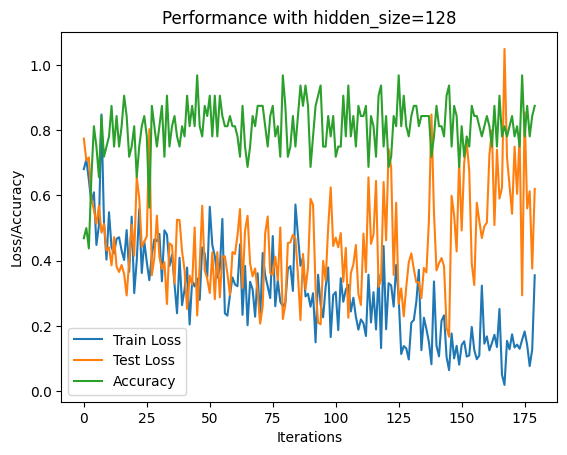

In [29]:
if __name__ == '__main__':
    results = {}
    hidden_sizes = [64, 128]
    run_model(results, hidden_sizes=hidden_sizes, run_recurrent=run_recurrent, use_RNN=use_RNN, reload_model=reload_model, atten_size=atten_size)
    for hidden_size, result in results.items():
      plt.figure()
      plt.plot(result['train_losses'], label='Train Loss')
      plt.plot(result['test_losses'], label='Test Loss')
      plt.plot(result['accuracies'], label='Accuracy')
      plt.title(f'Performance with hidden size of{hidden_size}')
      plt.xlabel('Iterations')
      plt.ylabel('Loss/Accuracy')
      plt.legend()
      plt.show()

In [ ]:
# import torch

# def infrance_model(model_path, test_data, run_recurrent=True, num_words=None):
#     model = torch.load(model_path)
#     model.eval()
#     with torch.no_grad():
#         for labels, reviews, reviews_text in test_data:
#             if run_recurrent:
#                 # Initialize hidden state based on batch size
#                 hidden_state = model.init_hidden(int(labels.shape[0]))

#                 for i in range(num_words):
#                     output, hidden_state = model(reviews[:, i, :], hidden_state)

#                 # Convert output tensor to predicted labels (assuming it's a classification task)
#                 predicted_labels = torch.argmax(output, dim=1)

#                 # Ensure labels and predicted_labels have compatible shapes
#                 if predicted_labels.size(0) != labels.size(0):
#                     raise RuntimeError("Batch sizes of predicted_labels and labels do not match")

#                 # Convert labels to class indices if they are one-hot encoded
#                 if labels.dim() > 1 and labels.size(1) > 1:
#                     labels = torch.argmax(labels, dim=1)

#                 # Calculate accuracy
#                 if labels.size(0) > 0:
#                     correct_predictions = (predicted_labels == labels).sum().item()
#                     total_predictions = labels.size(0)
#                     accuracy = correct_predictions / total_predictions
#                     print(f"Accuracy: {accuracy:.2f}")

#                 # Print results for each sample
#                 for text, golden, predicted in zip(reviews_text, labels, predicted_labels):
#                     print(f"Review Text: {text}")
#                     print(f"Golden Label: {golden.item()}, Predicted Label: {predicted.item()}")

In [16]:
# model_paths = [
#     "RNN.pth",
#     # "GRU.pth",
#     # "MLP.pth",
#     # "MLP_atten.pth"
# ]

# for model_path in model_paths:
#     infrance_model(model_path, test_dataset, run_recurrent=run_recurrent, num_words=num_words)

NameError: name 'infrance_model' is not defined

In [30]:
def inference_model(model_path, test_dataset, run_recurrent=True, num_words=None):
    # Load the model
    model = torch.load(model_path)
    model.eval()

    results = []

    for review, label in zip(my_test_texts, my_test_labels):
        # Preprocess the review
        processed_review = preprocess_review(review)

        # Initialize hidden state
        hidden = model.init_hidden(1)  # Batch size is 1 for inference

        # Run inference
        with torch.no_grad():
            output = None
            for i in range(processed_review.size(1)):  # Iterate over time steps
                input_step = processed_review[:, i, :]
                output, hidden = model(input_step, hidden)

        # Get the predicted label
        predicted_label = "pos" if output[0][0] > output[0][1] else "neg"

        results.append({
            "review": review,
            "true_label": label,
            "predicted_label": predicted_label,
            "confidence": max(output[0]).item()
        })

    return results

# Function to print results
def print_results(model_name, results):
    print(f"\nResults for {model_name}:")
    for result in results:
        print(f"Review: {result['review'][:150]}...")
        print(f"True label: {result['true_label']}")
        print(f"Predicted label: {result['predicted_label']}")
        print(f"Confidence: {result['confidence']:.4f}")
        print()

# Run inference for each model
model_paths = [
    # "RNN.pth",
    "GRU.pth",
    # "MLP.pth",
    # "MLP_atten.pth"
]

for model_path in model_paths:
    results = inference_model(model_path, None)  # We don't need test_dataset here
    print_results(model_path, results)


Results for GRU.pth:
Review:  The movie had stunning cinematography and top-notch acting,        which I really enjoyed. However, the plot was disappointing and lacked coherence. ...
True label: neg
Predicted label: neg
Confidence: 5.7739

Review: An emotionally charged masterpiece, blending nuanced acting with          a captivating storyline. The cinematography paints each scene with artistic ...
True label: pos
Predicted label: pos
Confidence: 4.2498

Review: The film offers a unique perspective, challenging conventions with its bold narrative choices.      The performances are subtly powerful, capturing th...
True label: pos
Predicted label: pos
Confidence: 5.8367

